<h3>Import necessary libraries</h3>

In [10]:
#Import library needed
import pandas as pd
import numpy as np
import nltk
from functools import reduce
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, ENGLISH_STOP_WORDS
from wordcloud import WordCloud
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/adikusuma/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

<h3>Read Data Source</h3>

In [4]:
#read
data=pd.read_csv('datasets/IMDB Dataset.csv')
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


<h2>Visualize Positive Review</h2>

(-0.5, 399.5, 199.5, -0.5)

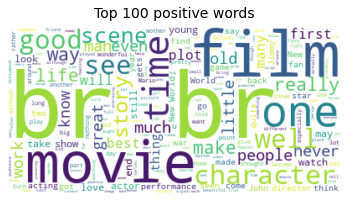

In [5]:
positive_data = data[data['sentiment'] == 'positive']['review'][:100]
positive_data = reduce(lambda a, b : a+b, positive_data)
cloud_positive = WordCloud(background_color='white').generate(positive_data)

plt.imshow(cloud_positive, interpolation='bilinear') 
plt.title('Top 100 positive words', y = 1.02, size = 14) 
plt.axis("off")

<h2>Visualize Negative Review</h2>

(-0.5, 399.5, 199.5, -0.5)

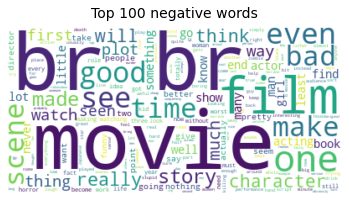

In [17]:
negative_data = data[data['sentiment'] == 'negative']['review'][:100]
negative_data = reduce(lambda a, b : a+b, negative_data)
cloud_negative = WordCloud(background_color='white').generate(negative_data)

plt.imshow(cloud_negative, interpolation='bilinear') 
plt.title('Top 100 negative words', y = 1.02, size = 14) 
plt.axis("off")


<h2>Check Balanced Data</h2>

In [7]:
print('Number of positive and negative sentiment:\n', data['sentiment'].value_counts())
print('Proportion of positive and negative sentiment:\n', data['sentiment'].value_counts()/len(data))

Number of positive and negative sentiment:
 positive    25000
negative    25000
Name: sentiment, dtype: int64
Proportion of positive and negative sentiment:
 positive    0.5
negative    0.5
Name: sentiment, dtype: float64


<h2>Check Longest and Shortest Review For Estimated Maximum Features</h2>

In [8]:
length_reviews = data.review.str.len()
print("Longest Review", max(length_reviews))
print("Shortest Review", min(length_reviews))

Longest Review 13704
Shortest Review 32


<h2>Tokenize Review Column</h2>

In [11]:
word_tokens = [word_tokenize(review) for review in data['review']]
data['n_words'] = [len(word_tokens[i]) for i in range(len(word_tokens))]
data.head()

,review,sentiment,n_words
0,One of the other reviewers has mentioned that ...,positive,380
1,A wonderful little production. <br /><br />The...,positive,201
2,I thought this was a wonderful way to spend ti...,positive,205
3,Basically there's a family where a little boy ...,negative,175
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,283


<h2>Using Tfidf For Weight Each Features</h2>

In [ ]:
vectorizer = TfidfVectorizer(stop_words=ENGLISH_STOP_WORDS, ngram_range=(1,2), max_features=500, token_pattern=r'\b[^\d\W][^\d\W]+\b')
vectorizer.fit(data['review'])
X = vectorizer.transform(data['review'])
df_transform = pd.DataFrame(data=X.toarray(), columns=vectorizer.get_feature_names_out())
df_transform.head()

,able,absolutely,act,acting,action,actor,actors,actress,actually,age,...,worth,wouldn,writer,writing,written,wrong,year,years,yes,young
0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.112975,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.00000
1,0.0,0.0,0.0,0.000000,0.000000,0.0,0.119063,0.0,0.0,0.0,...,0.140542,0.000000,0.0,0.0,0.157136,0.0,0.0,0.000000,0.0,0.00000
2,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.148932,0.0,0.16372
3,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.00000
4,0.0,0.0,0.0,0.075084,0.100541,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.00000


<h2>Transform Data for Define X and y</h2>

In [ ]:
dropped = data.drop(['review', 'n_words'], axis=1)
transform = pd.concat([dropped, df_transform], axis=1)
transform.head()

,sentiment,able,absolutely,act,acting,action,actor,actors,actress,actually,...,worth,wouldn,writer,writing,written,wrong,year,years,yes,young
0,positive,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,...,0.000000,0.112975,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.00000
1,positive,0.0,0.0,0.0,0.000000,0.000000,0.0,0.119063,0.0,0.0,...,0.140542,0.000000,0.0,0.0,0.157136,0.0,0.0,0.000000,0.0,0.00000
2,positive,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.148932,0.0,0.16372
3,negative,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.00000
4,positive,0.0,0.0,0.0,0.075084,0.100541,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.00000


<h2>Define X, y, Split Train Test Data, and Calculate Accuracy Score </h2>

In [ ]:
y = transform['sentiment']
X = transform.drop(['sentiment'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=456)
log_reg = LogisticRegression().fit(X_train, y_train)
y_predicted = log_reg.predict(X_test)

print('Accuracy on the train set: ', log_reg.score(X_train, y_train))
print('Accuracy on the test set: ', log_reg.score(X_test, y_test))
print('Accuracy on the test set: ', accuracy_score(y_test, y_predicted))
print(confusion_matrix(y_test, y_predicted)/len(y_test))

Accuracy on the train set:  0.844075
Accuracy on the test set:  0.8333
Accuracy on the test set:  0.8333
[[0.4074 0.089 ]
 [0.0777 0.4259]]


<h2>Calculate Confusion Matrix</h2>

/Users/adikusuma/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


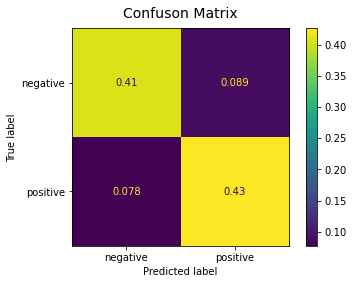

In [ ]:
plot_confusion_matrix(log_reg, X_test, y_test, normalize='all')
plt.title('Confuson Matrix', y=1.02, size=14)
plt.show() 